# DesInventar Colombia Data with pystac-monty

This notebook demonstrates how to use pystac-monty to process DesInventar Colombia disaster data and visualize it using interactive maps. We'll:

1. Download the DesInventar Colombia dataset
2. Convert the data to STAC items using pystac-monty
3. Display events on an interactive map
4. Allow selection of events to view related impacts
5. Explore the Monty STAC model and its metadata

Let's begin by importing the necessary libraries.

In [1]:
# Basic libraries
import json
import os
import tempfile
from datetime import datetime, timedelta
from pathlib import Path

# Visualization libraries
import folium
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# STAC and pystac-monty
import pystac
import pytz
import requests
from folium.plugins import MarkerCluster
from IPython.display import HTML, clear_output, display

from pystac_monty.extension import HazardDetail, ImpactDetail, MontyEstimateType, MontyExtension
from pystac_monty.geocoding import WorldAdministrativeBoundariesGeocoder
from pystac_monty.hazard_profiles import MontyHazardProfiles
from pystac_monty.sources.desinventar import DesinventarDataSource, DesinventarTransformer

## 1. Download and Process DesInventar Colombia Data

First, let's download the DesInventar Colombia dataset and initialize the data source and transformer.

In [2]:
# Define DesInventar Colombia dataset URL
colombia_url = "https://www.desinventar.net/DesInventar/download/DI_export_col.zip"
country_code = "col"
iso3 = "COL"

# Download the dataset
print(f"Downloading DesInventar Colombia dataset from {colombia_url}...")
response = requests.get(colombia_url)
tmp_zip_file = tempfile.NamedTemporaryFile(suffix=".zip", delete=False)
tmp_zip_file.write(response.content)
print(f"Downloaded {len(response.content) / (1024*1024):.2f} MB")

# Initialize the data source and transformer
data_source = DesinventarDataSource(tmp_zip_file, country_code, iso3, colombia_url)
transformer = DesinventarTransformer(data_source)

# Initialize the geocoder
geocoder = WorldAdministrativeBoundariesGeocoder('../tests/data-files/world-administrative-boundaries.fgb')

Downloaded 15.77 MB


## 2. Create STAC Items from DesInventar Data

Now, let's transform the DesInventar data into STAC items.

In [3]:
# Create STAC items
print("Creating STAC items from DesInventar Colombia data...")
all_stac_items = transformer.get_items()
print(f"Created {len(all_stac_items)} STAC items")

Creating STAC items from DesInventar Colombia data...

NOTE: cannot map events for:
 {
  "INTOXICACION": 772,
  "FORESTFIRE": 18700,
  "STRUCTURE": 1318,
  "HEATWAVE": 38,
  "STRONGWIND": 11288,
  "SPATE": 2748,
  "ELECTRICSTORM": 506,
  "COASTLINE": 12,
  "Erosión": 88,
  "Naufragio": 54
}
Created 84590 STAC items


In [4]:
# Separate the STAC items by role
event_items = []
impact_items = []

for item in all_stac_items:
    roles = item.properties.get('roles', [])
    if 'event' in roles:
        event_items.append(item)
    elif 'impact' in roles:
        impact_items.append(item)

print(f"Events: {len(event_items)}, Impacts: {len(impact_items)}")

Events: 35929, Impacts: 48661


## 3. Analyze the Event Data

Let's create a DataFrame to analyze the event data.

In [5]:
# Extract relevant information into a DataFrame
events_df = pd.DataFrame([
    {
        'id': item.id,
        'title': item.properties.get('title', ''),
        'datetime': item.datetime,
        'hazard_codes': MontyExtension.ext(item).hazard_codes,
        'country_codes': MontyExtension.ext(item).country_codes,
        'latitude': item.bbox[1] if item.bbox else None,
        'longitude': item.bbox[0] if item.bbox else None,
    } for item in event_items if item.bbox
])

# Display the DataFrame
events_df.head()

,id,title,datetime,hazard_codes,country_codes,latitude,longitude
0,desinventar-event-COL-1977-0039,OTHER in None on 1977-01-21 00:00:00+00:00,1977-01-21 00:00:00+00:00,[OT],[COL],3.730549,-74.456717
1,desinventar-event-COL-1977-0042,FIRE in Pueblonuevo. on 1977-01-23 00:00:00+00:00,1977-01-23 00:00:00+00:00,"[EN0013, nat-cli-wil-wil]",[COL],3.730549,-74.456717
2,desinventar-event-COL-1977-0044,SURGE in Salgar on 1977-01-26 00:00:00+00:00,1977-01-26 00:00:00+00:00,"[MH0027, nat-met-sto-sur]",[COL],3.730549,-74.456717
3,desinventar-event-COL-1977-0045,FIRE in parquedaero ubicado en la crr 8 con ...,1977-01-28 00:00:00+00:00,"[EN0013, nat-cli-wil-wil]",[COL],3.730549,-74.456717
4,desinventar-event-COL-1977-0048,HAILSTORM in None on 1977-02-03 00:00:00+00:00,1977-02-03 00:00:00+00:00,"[MH0036, nat-met-sto-hai]",[COL],3.730549,-74.456717


In [6]:
# Count events by hazard type
hazard_counts = {}
for item in event_items:
    hazard_codes = MontyExtension.ext(item).hazard_codes
    if hazard_codes:
        for code in hazard_codes:
            hazard_counts[code] = hazard_counts.get(code, 0) + 1

# Sort by count
sorted_hazards = sorted(hazard_counts.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame
hazard_df = pd.DataFrame(sorted_hazards, columns=['Hazard Code', 'Count'])

# Display the top 10 hazard types
hazard_df.head(10)

,Hazard Code,Count
0,nat-hyd-flo-flo,17093
1,GH0007,10522
2,nat-hyd-mmw-lan,10522
3,EN0013,3698
4,nat-cli-wil-wil,3698
5,nat-met-sto-sto,1300
6,GH0001,1037
7,nat-geo-ear-grd,1037
8,MH0035,821
9,nat-met-dro-dro,821


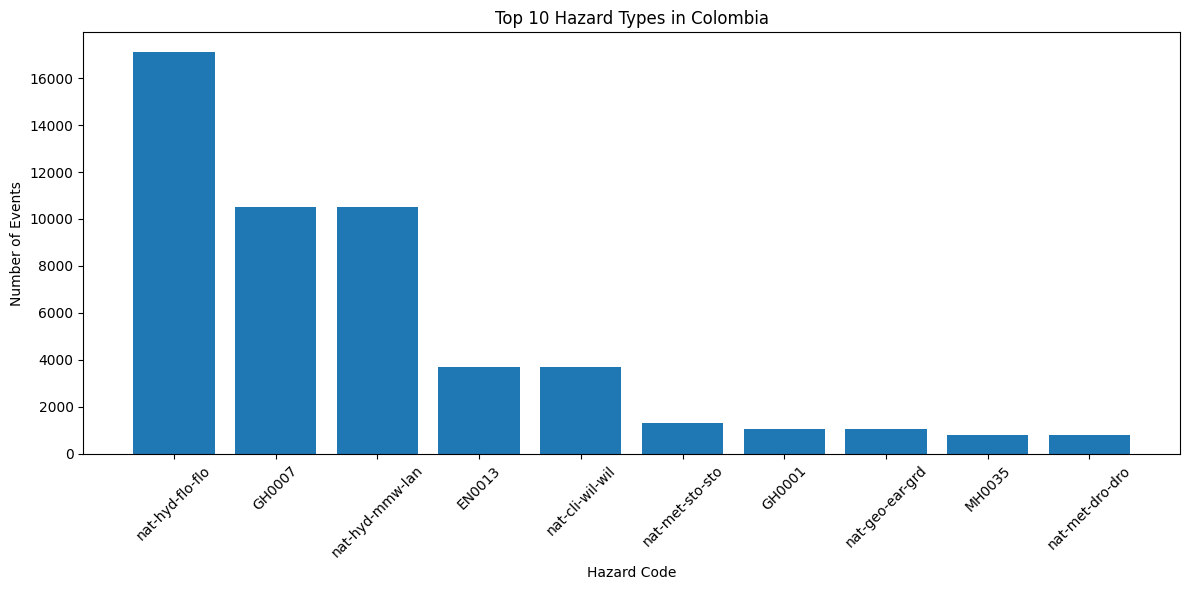

In [7]:
# Plot the top 10 hazard types
plt.figure(figsize=(12, 6))
top_hazards = hazard_df.head(10)
plt.bar(top_hazards['Hazard Code'], top_hazards['Count'])
plt.title('Top 10 Hazard Types in Colombia')
plt.xlabel('Hazard Code')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Displaying Events on a Map

Now, let's create an interactive map to display the events.

In [8]:
# Function to create a map of events
def create_event_map(event_items, max_events=1000):
    # Filter events with valid coordinates
    valid_events = [item for item in event_items if item.bbox]
    
    # Limit the number of events to display
    if len(valid_events) > max_events:
        print(f"Limiting display to {max_events} events out of {len(valid_events)}")
        valid_events = valid_events[:max_events]
    else:
        print(f"Displaying all {len(valid_events)} events")
    
    # Calculate the average latitude and longitude for map centering
    if not valid_events:
        return folium.Map(location=[4.5709, -74.2973], zoom_start=6)  # Center on Colombia
    
    lats = [item.bbox[1] for item in valid_events]
    lons = [item.bbox[0] for item in valid_events]
    center_lat = sum(lats) / len(lats)
    center_lon = sum(lons) / len(lons)
    
    # Create the map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=6, tiles='CartoDB positron')
    
    # Add a title
    title_html = '''
    <h3 align="center" style="font-size:20px">
        <b>DesInventar Colombia Disaster Events</b>
    </h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Create a marker cluster group
    marker_cluster = MarkerCluster(name="Events").add_to(m)
    
    # Add markers for each event
    for item in valid_events:
        # Get the event properties
        monty = MontyExtension.ext(item)
        hazard_codes = monty.hazard_codes
        title = item.properties.get('title')
        date_time = item.datetime.strftime('%Y-%m-%d') if item.datetime else 'Unknown'
        
        # Determine color based on hazard type
        if hazard_codes and 'nat-hyd-flo-flo' in hazard_codes:  # Flood
            color = 'blue'
        elif hazard_codes and 'nat-hyd-mmw-lan' in hazard_codes:  # Landslide
            color = 'orange'
        elif hazard_codes and 'nat-geo-ear-grd' in hazard_codes:  # Earthquake
            color = 'red'
        elif hazard_codes and 'nat-cli-wil-wil' in hazard_codes:  # Fire
            color = 'darkred'
        elif hazard_codes and 'nat-met-sto-sto' in hazard_codes:  # Storm
            color = 'purple'
        else:
            color = 'gray'
        
        # Create popup content
        popup_content = f"""
        <b>{title}</b><br>
        <b>Date:</b> {date_time}<br>
        <b>ID:</b> {item.id}<br>
        <b>Hazard Codes:</b> {', '.join(hazard_codes) if hazard_codes else 'Unknown'}<br>
        """
        
        # Add marker to the cluster
        folium.CircleMarker(
            location=[item.bbox[1], item.bbox[0]],
            radius=5,
            color=color,
            fill=True,
            fill_opacity=0.7,
            popup=folium.Popup(popup_content, max_width=300),
            tooltip=title
        ).add_to(marker_cluster)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    return m

# Create the event map
event_map = create_event_map(event_items)
event_map

Limiting display to 1000 events out of 35929


## 5. Selecting Events to View Impacts

Now, let's create a simple interface to select an event and view its associated impacts.

In [9]:
# Create a dropdown widget for selecting events
# Limit to events with valid coordinates and impacts
valid_events = [item for item in event_items if item.bbox]
event_options = [(f"{item.properties.get('title')} ({item.id})", item.id) for item in valid_events[:100]]

event_dropdown = widgets.Dropdown(
    options=event_options,
    description='Select Event:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='80%')
)

# Create an output widget for displaying the map
map_output = widgets.Output()

# Function to find impact items for a given event ID
def find_related_impacts(event_id):
    # Extract the DesInventar ID from the event ID (format: desinventar-event-{iso3}-{serial})
    parts = event_id.split('-')
    if len(parts) >= 4:
        serial = parts[-1]
        # Find related impact items
        related_impacts = [item for item in impact_items if serial in item.id]
        return related_impacts
    return []

# Function to create a map showing impacts for a selected event
def create_detail_map(event_id):
    # Find the selected event
    selected_event = next((item for item in event_items if item.id == event_id), None)
    
    if not selected_event or not selected_event.bbox:
        return folium.Map(location=[4.5709, -74.2973], zoom_start=6)  # Center on Colombia
    
    # Find related impacts
    related_impacts = find_related_impacts(event_id)
    
    # Get event coordinates
    event_lat = selected_event.bbox[1]
    event_lon = selected_event.bbox[0]
    
    # Create the map centered on the event
    m = folium.Map(location=[event_lat, event_lon], zoom_start=8, tiles='CartoDB positron')
    
    # Add a title
    title = selected_event.properties.get('title', 'Event Details')
    title_html = f'''
    <h3 align="center" style="font-size:20px">
        <b>{title}</b>
    </h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Create popup content for the event
    monty = MontyExtension.ext(selected_event)
    hazard_codes = monty.hazard_codes
    date_time = selected_event.datetime.strftime('%Y-%m-%d') if selected_event.datetime else 'Unknown'
    
    event_popup = f"""
    <b>{title}</b><br>
    <b>Date:</b> {date_time}<br>
    <b>ID:</b> {selected_event.id}<br>
    <b>Hazard Codes:</b> {', '.join(hazard_codes) if hazard_codes else 'Unknown'}<br>
    """
    
    # Add event marker
    folium.CircleMarker(
        location=[event_lat, event_lon],
        radius=8,
        color='red',
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(event_popup, max_width=300),
        tooltip="Event Location"
    ).add_to(m)
    
    # Add impact information
    if related_impacts:
        # Create a table of impacts
        impact_html = "<h4>Impact Information</h4><table style='width:100%'><tr><th>Type</th><th>Value</th><th>Unit</th></tr>"
        
        for impact in related_impacts:
            # Get impact details from Monty extension
            monty = MontyExtension.ext(impact)
            impact_detail = monty.impact_detail
            
            if impact_detail:
                impact_html += f"<tr><td>{impact_detail.type}</td><td>{impact_detail.value}</td><td>{impact_detail.unit}</td></tr>"
        
        impact_html += "</table>"
        
        # Add the impact information as a popup to the event location
        folium.Popup(impact_html, max_width=400).add_to(m)
        
        # Add impact polygons if they have different geometries
        for impact in related_impacts:
            if impact.geometry and impact.geometry != selected_event.geometry:
                # Get impact details from Monty extension
                monty = MontyExtension.ext(impact)
                impact_detail = monty.impact_detail
                
                # Determine color based on impact type
                if impact_detail and impact_detail.type == "DEATH":
                    color = 'darkred'
                    label = "Fatalities"
                elif impact_detail and impact_detail.type == "INJURED":
                    color = 'orange'
                    label = "Injuries"
                elif impact_detail and impact_detail.type == "LOSS_COST":
                    color = 'purple'
                    label = "Economic Losses"
                elif impact_detail and impact_detail.type == "DAMAGED":
                    color = 'blue'
                    label = "Damages"
                else:
                    color = 'gray'
                    label = "Impact"
                
                # Create popup content for the impact
                impact_popup = f"""
                <b>{impact.properties.get('title')}</b><br>
                <b>ID:</b> {impact.id}<br>
                <b>Category:</b> {impact_detail.category if impact_detail else 'N/A'}<br>
                <b>Type:</b> {impact_detail.type if impact_detail else 'N/A'}<br>
                <b>Value:</b> {impact_detail.value if impact_detail else 'N/A'} {impact_detail.unit if impact_detail else ''}<br>
                <b>Estimate Type:</b> {impact_detail.estimate_type.value if impact_detail else 'N/A'}<br>
                """
                
                # Add impact polygon
                if impact.geometry and impact.geometry['type'] == 'Polygon':
                    # Convert coordinates from [lon, lat] to [lat, lon] for folium
                    coords = impact.geometry['coordinates'][0]
                    folium_coords = [[coord[1], coord[0]] for coord in coords]
                    
                    folium.Polygon(
                        locations=folium_coords,
                        color=color,
                        weight=2,
                        fill=True,
                        fill_opacity=0.3,
                        popup=folium.Popup(impact_popup, max_width=300),
                        tooltip=label
                    ).add_to(m)
    else:
        # Add a note if no impacts are found
        folium.Marker(
            location=[event_lat, event_lon],
            popup="No impact data available for this event",
            icon=folium.Icon(color="gray", icon="info-sign")
        ).add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    return m

# Function to handle dropdown changes
def on_dropdown_change(change):
    with map_output:
        clear_output()
        event_id = change.new
        detail_map = create_detail_map(event_id)
        display(detail_map)

# Display the dropdown and map
event_dropdown.observe(on_dropdown_change, names='value')
display(event_dropdown)
display(map_output)

Dropdown(description='Select Event:', layout=Layout(width='80%'), options=(('OTHER in None on 1977-01-21 00:00…

Output()

## 6. Analyzing Impact Data

Let's analyze the impact data to understand the distribution of different types of impacts.

In [10]:
# Extract impact information into a DataFrame
impacts_df = pd.DataFrame([
    {
        'id': item.id,
        'event_id': '-'.join(item.id.split('-')[:-1]),
        'type': MontyExtension.ext(item).impact_detail.type if MontyExtension.ext(item).impact_detail else None,
        'category': MontyExtension.ext(item).impact_detail.category if MontyExtension.ext(item).impact_detail else None,
        'value': MontyExtension.ext(item).impact_detail.value if MontyExtension.ext(item).impact_detail else None,
        'unit': MontyExtension.ext(item).impact_detail.unit if MontyExtension.ext(item).impact_detail else None,
    } for item in impact_items if MontyExtension.ext(item).impact_detail
])

# Display the DataFrame
impacts_df.head()

,id,event_id,type,category,value,unit
0,desinventar-impact-1977-0042-injured,desinventar-impact-1977-0042,injured,people,3.0,count
1,desinventar-impact-1977-0042-houses_destroyed,desinventar-impact-1977-0042,destroyed,buildings,1.0,count
2,desinventar-impact-1977-0045-losses_local_curr...,desinventar-impact-1977-0045,cost,local_currency,1500000.0,Unknown
3,desinventar-impact-1977-0048-houses_destroyed,desinventar-impact-1977-0048,destroyed,buildings,1.0,count
4,desinventar-impact-1977-0052-losses_local_curr...,desinventar-impact-1977-0052,cost,local_currency,10000000.0,Unknown


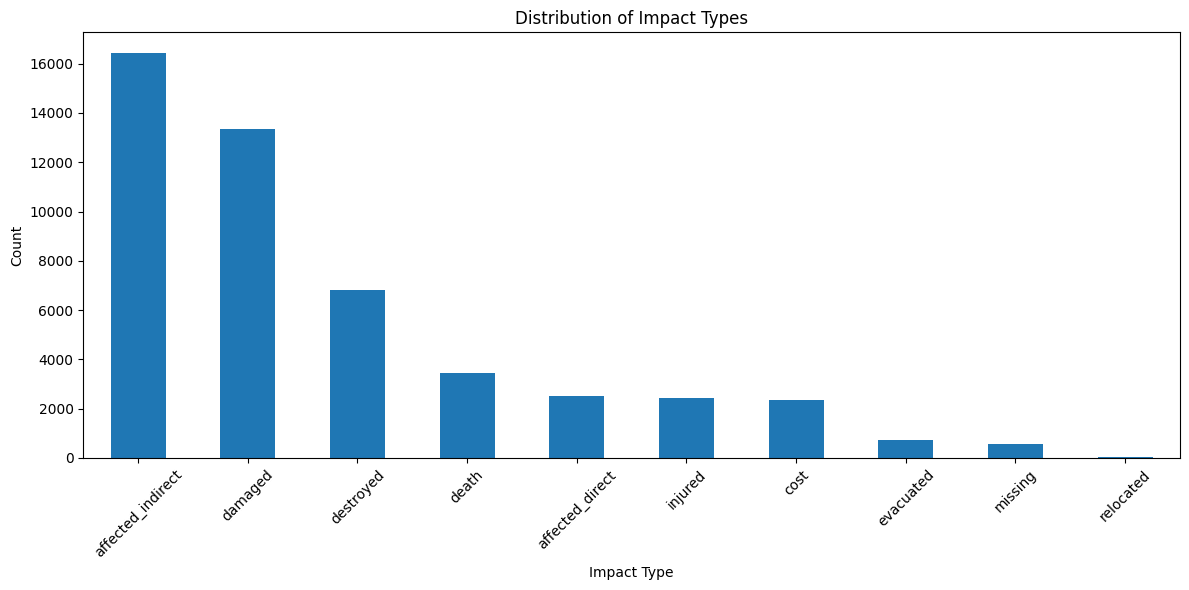

In [11]:
# Count impacts by type
impact_type_counts = impacts_df['type'].value_counts()

# Plot the impact types
plt.figure(figsize=(12, 6))
impact_type_counts.plot(kind='bar')
plt.title('Distribution of Impact Types')
plt.xlabel('Impact Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Analyze deaths by summing values where type is DEATH
deaths_df = impacts_df[impacts_df['type'] == 'DEATH']
total_deaths = deaths_df['value'].sum()
print(f"Total reported deaths: {total_deaths}")

# Analyze injuries
injuries_df = impacts_df[impacts_df['type'] == 'INJURED']
total_injuries = injuries_df['value'].sum()
print(f"Total reported injuries: {total_injuries}")

# Analyze economic losses (in USD)
losses_df = impacts_df[(impacts_df['type'] == 'LOSS_COST') & (impacts_df['unit'] == 'USD')]
total_losses = losses_df['value'].sum()
print(f"Total reported economic losses: ${total_losses:,.2f} USD")

Total reported deaths: 0.0
Total reported injuries: 0.0
Total reported economic losses: $0.00 USD


## 7. Conclusion

In this notebook, we've demonstrated how to use pystac-monty to process DesInventar Colombia disaster data and visualize it using interactive maps. We've:

1. Downloaded and processed the DesInventar Colombia dataset
2. Converted the data to STAC items using pystac-monty
3. Displayed events on an interactive map
4. Created an interface to select events and view their impacts
5. Analyzed the distribution of hazard types and impacts

This approach can be applied to other DesInventar country datasets to analyze disaster data from different regions.